In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('../data/acled_covid19.csv')
print(df.columns)
df.head()

Index(['Unnamed: 0', 'data_id', 'iso', 'event_id_cnty', 'event_id_no_cnty',
       'event_date', 'year', 'time_precision', 'event_type', 'sub_event_type',
       'actor1', 'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2',
       'inter2', 'interaction', 'region', 'country', 'admin1', 'admin2',
       'admin3', 'location', 'latitude', 'longitude', 'geo_precision',
       'source', 'source_scale', 'notes', 'fatalities', 'timestamp', 'iso3'],
      dtype='object')


,Unnamed: 0,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,...,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3
0,0,9498574,862,VEN12964,12964,2022-09-17,2022,1,Protests,Peaceful protest,...,Ciudad Bolivar,8.1292,-63.5409,1,Diario Primicia,Subnational,"On 17 September 2022, in Ciudad Bolivar (Boliv...",0,1664226314,VEN
1,1,9491030,410,KOR25174,25174,2022-09-16,2022,1,Protests,Peaceful protest,...,Seoul City - Seocho,37.4744,127.0304,1,EDaily,National,"On 16 September 2022, members of the All-Korea...",0,1663685720,KOR
2,2,9491038,156,CHN12137,12137,2022-09-15,2022,1,Protests,Peaceful protest,...,Hong Kong - Central and Western,22.2811,114.1598,1,HK01,Subnational,"On 15 September 2022, three representatives of...",0,1663685720,CHN
3,3,9491260,410,KOR25204,25204,2022-09-15,2022,1,Protests,Peaceful protest,...,Seoul City - Yeongdeungpo,37.5223,126.9075,1,YNA,National,"On 15 September 2022, members of the COVID-19 ...",0,1663685720,KOR
4,4,9492137,250,FRA18626,18626,2022-09-15,2022,1,Protests,Peaceful protest,...,Pau,43.2951,-0.3708,1,France Bleu,National,"On 15 September 2022, around 30 opponents of c...",0,1663691322,FRA


## NOTES FROM PARTER MEETING 9/10/22
________________________________________________________________
#### use SpaCy to grab nouns/verbs, use their tagging functions to grab instances of people, geolocations, etc.
#### after getting this data, create features/attributes based on the data and join to the individual sources. Cluster
#### on datasets aggregated by sources and by country (and anything else we think of)

#### cluster word vectors (maps to dimensions and takes euclidean or other distances)
#### overall, try a lot of clustering

#### if we want to dive even deeper into NLP nuances, prof uploaded NLP video on onedrive (use second link not first)

#### characterizing the sources themselves by quality or anything else could be good idea
#### , (whats a good source for information x), who reports factual, who uses adjectives, etc.

In [2]:
cols = ['source', 'source_scale', 'notes']
sources = df[cols]

# some combinations of sources are in different orders. Creating source_cleaned to fix this
sources['source_cleaned'] = [str(sorted(s.split('; '))) for s in sources['source']]

sources.head(10)

C:\Users\15714\AppData\Local\Temp/ipykernel_18860/1300603276.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sources['source_cleaned'] = [str(sorted(s.split('; '))) for s in sources['source']]


,source,source_scale,notes,source_cleaned
0,Diario Primicia,Subnational,"On 17 September 2022, in Ciudad Bolivar (Boliv...",['Diario Primicia']
1,EDaily,National,"On 16 September 2022, members of the All-Korea...",['EDaily']
2,HK01,Subnational,"On 15 September 2022, three representatives of...",['HK01']
3,YNA,National,"On 15 September 2022, members of the COVID-19 ...",['YNA']
4,France Bleu,National,"On 15 September 2022, around 30 opponents of c...",['France Bleu']
5,CBS News,National,"On 15 September 2022, parents and students hel...",['CBS News']
6,CR Hoy,National,"On 14 September 2022, in San Jose, San Jose, f...",['CR Hoy']
7,Diario Extra,National,"On 13 September 2022, in San Jose, San Jose, w...",['Diario Extra']
8,Manila Bulletin,National,"On 12 September 2022, health workers led by su...",['Manila Bulletin']
9,Mitteldeutschen Zeitung; Mitteldeutscher Rundfunk,National,"On 12 September 2022, around 850 people demons...","['Mitteldeutschen Zeitung', 'Mitteldeutscher R..."


<AxesSubplot:xlabel='count', ylabel='source_scale'>

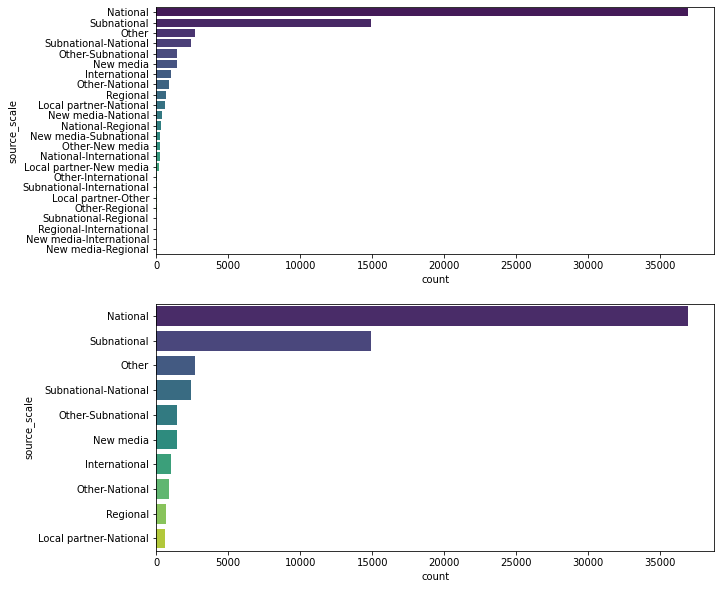

In [3]:
fig, ax = plt.subplots(2, figsize=(10, 10))
palette = 'viridis'

sns.countplot(ax=ax[0],palette=palette, y=sources['source_scale'], order=pd.value_counts(sources['source_scale']).index)
sns.countplot(ax=ax[1],palette=palette, y=sources['source_scale'], order=pd.value_counts(sources['source_scale'])[:10].index)

#### It looks like the majority of entries are on a national scale.

In [4]:
# Since sources that appear to report the same event are separated by a semicolon, we have to expand this column to get the
# count of times a source has reported on an event
sources_list = list()
for s in sources['source']:
    for i in s.split('; '):
        sources_list.append(i)

In [5]:
# putting into Pandas df to get counts
source_expanded = pd.DataFrame({'source': sources_list})
source_expanded.groupby('source')['source'].size().reset_index(name='count').sort_values('count', axis=0, ascending=False)

,source,count
1777,G1,1544
1050,Crowd Counting Consortium,1177
4743,Times of India,1006
1743,France 3 Regions,832
4836,Twitter,782
...,...,...
920,City Press (South Africa),1
3532,Nordfront Denmark,1
3528,Norba Online,1
924,Claremont Courier,1


<AxesSubplot:xlabel='count', ylabel='source'>

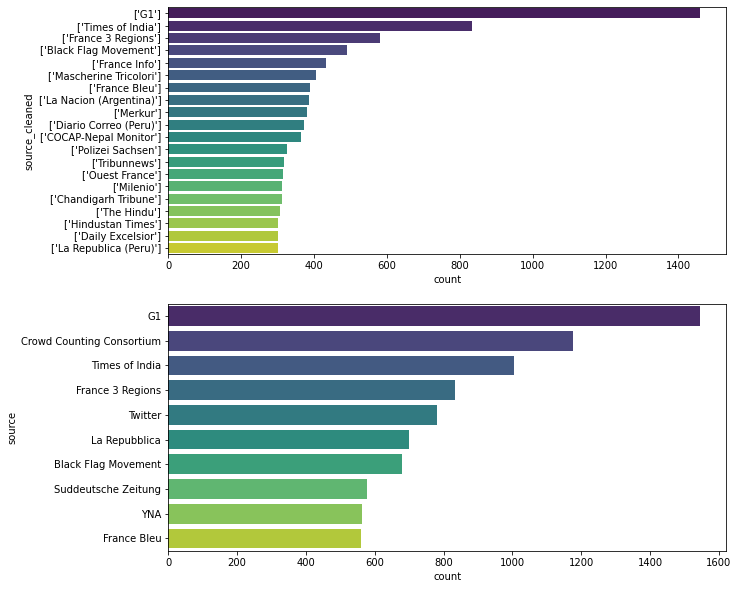

In [6]:
fig, ax = plt.subplots(2, figsize=(10, 10))
palette = 'viridis'

# Plot of sources
sns.countplot(ax=ax[0], palette=palette, y=sources['source_cleaned'], order=pd.value_counts(sources['source_cleaned']).iloc[:20].index)

# Plot of individually counted sources
sns.countplot(ax=ax[1], palette=palette, y=source_expanded['source'], order=pd.value_counts(source_expanded['source']).iloc[:10].index)

### Yemen Data Project appears very common in the individually counted sources, but raw sources only show the source paired with another source.

### Exploring these below:

<AxesSubplot:xlabel='count', ylabel='source_cleaned'>

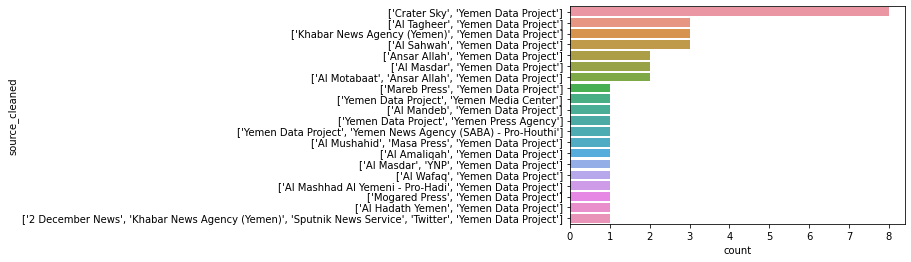

In [7]:
yemen = sources[sources['source_cleaned'].str.contains('Yemen Data Project')]
sns.countplot(y=yemen['source_cleaned'], order=pd.value_counts(yemen['source_cleaned']).iloc[:20].index)

# NLP on 'notes' column

In [8]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist

from wordcloud import WordCloud


# tokenizer that removes punctuation
tokenizer = RegexpTokenizer(r'\w+')

lemmatizer = WordNetLemmatizer()

# creating one big string of all of the values in the 'notes' column
text = ''
for n in sources['notes']:
    text += n + ' '
    
tokens = tokenizer.tokenize(text)

# lemmatizing words
lem_words = [lemmatizer.lemmatize(w) for w in tokens]

# getting frequency distribution
dist_lem = FreqDist(lem_words)

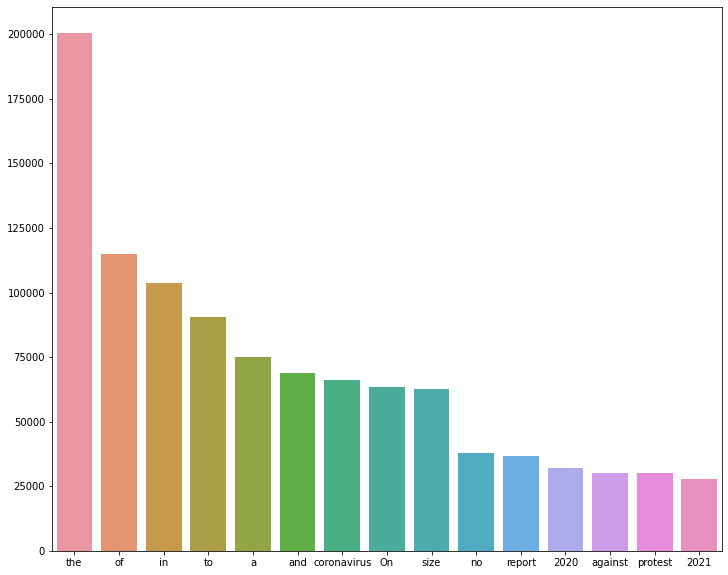

In [9]:
# plotting most common words
top_common = dist_lem.most_common(15)
pdser = pd.Series(dict(top_common))

fig, ax = plt.subplots(figsize=(12,10))
all_plot = sns.barplot(x=pdser.index, y=pdser.values)

#### Looks like there were some stopwords. Removing those and trying again.

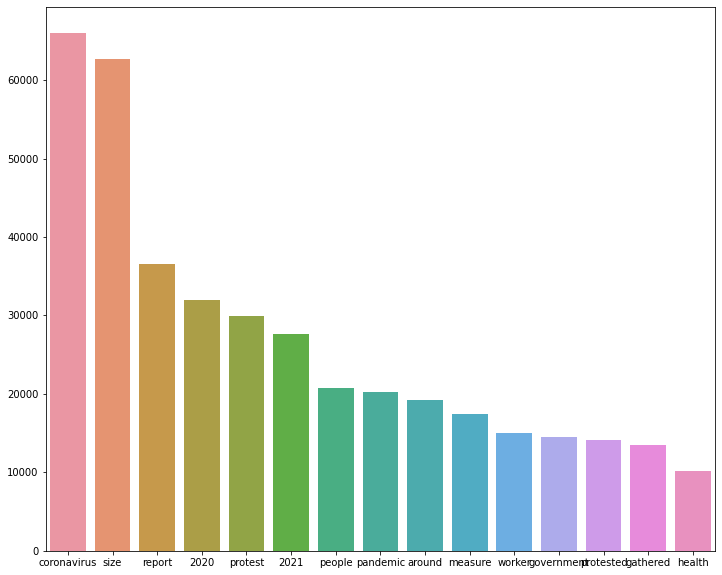

In [10]:
# removing stopwords and replotting

stop_words = set(stopwords.words('english'))
tokens_cleaned = [w for w in tokens if w.lower() not in stop_words]

lem_words_cleaned = [lemmatizer.lemmatize(w) for w in tokens_cleaned]
dist_lem_cleaned = FreqDist(lem_words_cleaned)

# plotting most common words
top_common = dist_lem_cleaned.most_common(15)
pdser = pd.Series(dict(top_common))

fig, ax = plt.subplots(figsize=(12,10))
all_plot = sns.barplot(x=pdser.index, y=pdser.values)

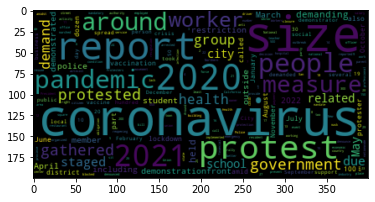

In [11]:
wc = WordCloud().generate_from_frequencies(dist_lem_cleaned)
plt.imshow(wc, interpolation='bilinear')

In [12]:
# applying nlp() wrapper to obtain SpaCy attributes
mytext = nlp(text)

# counting named entities
labels = [x.label_ for x in mytext.ents]
counts = Counter(labels)
counts

NameError: name 'nlp' is not defined

# Creating DataFrame of joined individual sources

In [ ]:
# First, we need a list of distinct sources
sources_distinct = list(set(sources_list))
sources_distinct_df = pd.DataFrame({'source_singular': sources_distinct})

# since eventually we're using a LIKE clause for the join, we need to add percentage wildcards here because we can't in pandasql.
sources_distinct_df['source_singular'] = sources_distinct_df['source_singular'].apply(lambda x: f'%{x}%')

# Second, join this df with the sources df with the help of pandasql

from pandasql import sqldf 
sql = lambda q: sqldf(q, globals())

expanded_source_df = sql('''
    SELECT * FROM df s
    JOIN sources_distinct_df sd
    ON s.source LIKE sd.source_singular
''')

# removing percentage wildcards
expanded_source_df['source_singular'] = expanded_source_df['source_singular'].apply(lambda x: x.replace('%', ''))
expanded_source_df.head()

#### Now, we can analyze singular sources based on other columns of interest.